### Quant GAN

금융 시계열의 특성과 모델링 문제를 간단히 정리하고, 이러한 특성이 신경망(NN) 유형 선택에 어떤 동기를 부여하는지 설명한다. 또한, 금융 시계열의 (데이터 기반) 모델링과 관련된 기존 문헌을 검토한다.
먼저, 특정 기간(예: 하루, 한 달 또는 1년) 동안의 주식 성과는 상대 수익률로 정의된다. 이는 다음과 같이 나타낼 수 있다.

$$R_t = \frac{S_t - S_{t-1}}{S_{t-1}}$$

또는 로그 수익률로 정의된다.

$$R_t = \log(S_t) - \log(S_{t-1})$$

따라서 자산 수익률을 생성하는 것이 주요 목적이다. 자산 수익률의 특징적인 속성은 잘 연구되어 있으며, 일반적으로 **stylized facts**로 알려져 있다. 가장 중요한 stylized facts은 다음과 같다 (Chakraborti et al. (2011); Cont (2001)):

- 자산 수익률은 정규분포보다 두터운 꼬리를 가진다.
- 자산 수익률의 분포는 정규분포보다 더 뾰족한 경향이 있다.
- 자산 수익률은 가격 변동성 측면에서 높은 활동과 낮은 활동의 단계를 나타내며, 이를 **변동성 클러스터링(volatility clustering)** 이라고 한다.
- 자산 수익률의 변동성은 수익률 과정과 음의 상관관계를 가지며, 이를 **레버리지 효과(leverage effect)** 라고 한다.
- 경험적으로 자산 수익률은 상관관계가 없지만 독립적이지는 않다.

금융 시계열 모델에 관한 방대한 문헌이 존재하며, 이는 다양한 이산 시간 GARCH 계열 모델(Bollerslev, 1986)에서부터 블랙-숄즈 모델(Black and Scholes, 1973), 헤스톤 모델(Heston, 1993) 및 러프 확장(El Euch et al., 2018)과 같은 연속 시간 모델에 이르기까지 다양하다. 그러나 새로운 모델의 개발과 혁신은 매우 어렵다. 예를 들어, 자산 가격이 기하 브라운 운동(geometric Brownian motion)으로 설명될 수 있다고 가정하는 블랙-숄즈 모델을 보다 정교하게 확장한 헤스톤 모델(변동성의 확률성과 레버리지 효과를 반영)을 개발하는 데 20년이 걸렸다.

In [1]:
import numpy as np
import pandas as pd

from scipy.optimize import fmin
from scipy.special import lambertw
from scipy.stats import kurtosis, norm

import torch
import torch.nn as nn
from torch.nn.utils import weight_norm
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
from tqdm import tqdm
import yfinance as yf
import random

device = torch.device("mps")
random.seed(42)
torch.manual_seed(42)

#### Neural Net Topology

이 섹션에서는 SVNNs(신경망 기반 확률적 변동성 모델)를 구성하는 데 필수적인 신경망(NN) 토폴로지를 소개한다. 먼저 다층 퍼셉트론(Multilayer Perceptron, MLP)을 정의한다. 이후 TCNs(Temporal Convolutional Networks)의 형식적인 정의를 제공한다.

In [4]:
data = yf.download(
    ['VTV'],
    start = '2015-01-01',
    end = '2025-01-12',
    progress = False,
    interval = '1d',
    auto_adjust=True,
    multi_level_index=False
)

In [5]:
log_ret = np.log(data['Close'] / data['Close'].shift(1))[1:]

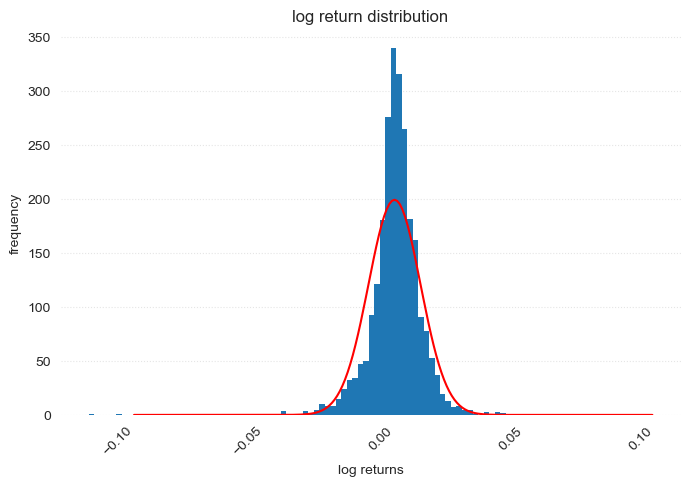

In [6]:
fig, ax = plt.subplots(figsize = (8, 5))

ax.hist(
    log_ret, 
    bins = 100,
    edgecolor = 'none'
)
x_axis = np.arange(-0.1, 0.1, 0.001)
ax.plot(
    x_axis, 
    norm.pdf(x_axis, 0, 0.01) * 5, 
    color= 'r'
)

for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
plt.xticks(rotation = 45, ha = 'right')
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xlabel('log returns')
plt.ylabel('frequency')
plt.title('log return distribution')
plt.show()

In [7]:
def delta_init(z):
    k = kurtosis(z, fisher=False, bias=False)
    if k < 166. / 62.:
        return 0.01
    return np.clip(1. / 66 * (np.sqrt(66 * k - 162.) - 6.), 0.01, 0.48)

def delta_gmm(z):
    delta = delta_init(z)

    def iter(q):
        u = W_delta(z, np.exp(q))
        if not np.all(np.isfinite(u)):
            return 0.
        k = kurtosis(u, fisher=True, bias=False)**2
        if not np.isfinite(k) or k > 1e10:
            return 1e10
        return k

    res = fmin(iter, np.log(delta), disp=0)
    return np.around(np.exp(res[-1]), 6)

def W_delta(z, delta):
    return np.sign(z) * np.sqrt(np.real(lambertw(delta * z ** 2)) / delta)

def W_params(z, params):
    return params[0] + params[1] * W_delta((z - params[0]) / params[1], params[2])

def inverse(z, params):
    return params[0] + params[1] * (z * np.exp(z * z * (params[2] * 0.5)))

def igmm(z, eps=1e-6, max_iter=100):
    delta = delta_init(z)
    params = [np.median(z), np.std(z) * (1. - 2. * delta) ** 0.75, delta]
    for k in range(max_iter):
        params_old = params
        u = (z - params[0]) / params[1]
        params[2] = delta_gmm(u)
        x = W_params(z, params)
        params[0], params[1] = np.mean(x), np.std(x)

        if np.linalg.norm(np.array(params) - np.array(params_old)) < eps:
            break
        if k == max_iter - 1:
            raise "Solution not found"

    return params

In [8]:
log_mean = np.mean(log_ret)
log_norm = log_ret - log_mean
params = igmm(log_norm)

In [9]:
processed = W_delta((log_norm - params[0]) / params[1], params[2])
log_max = np.max(np.abs(processed))
processed /= log_max

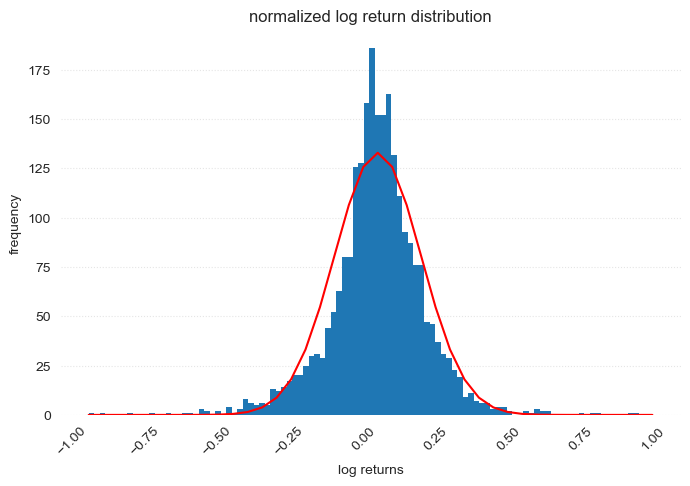

In [15]:
fig, ax = plt.subplots(figsize = (8, 5))

ax.hist(
    processed, 
    bins = 100,
    edgecolor = 'none'
)
x_axis = np.arange(-1, 1, 0.05)
ax.plot(
    x_axis, 
    norm.pdf(x_axis, 0, 0.15) * 50, 
    color= 'r'
)

for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
plt.xticks(rotation = 45, ha = 'right')
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xlabel('log returns')
plt.ylabel('frequency')
plt.title('normalized log return distribution')
plt.show()

In [16]:
class DataLoader(Dataset) :
    def __init__(self, data, window):
        self.data = data
        self.window = window
    
    def __getitem__(self, index):
        x = np.expand_dims(self.data[index : index + self.window], -1)
        return torch.from_numpy(x).float()

    def __len__(self):
        return len(self.data) - self.window

In [17]:
class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_outputs, kernel_size, dilation):
        super(TemporalBlock, self).__init__()
        self.conv1 = nn.Conv1d(n_inputs, n_hidden, kernel_size, stride=1, dilation=dilation, padding='same')

        self.relu1 = nn.PReLU()
        self.conv2 = nn.Conv1d(n_hidden, n_outputs, kernel_size, stride=1, dilation=dilation, padding='same')
        self.relu2 = nn.PReLU()

        self.net = nn.Sequential(self.conv1, self.relu1, self.conv2, self.relu2)

        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None

        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return out + res

class TCN(nn.Module):
    def __init__(self, input_size, output_size, n_hidden=80):
        super(TCN, self).__init__()
        layers = []
        for i in range(7):
            num_inputs = input_size if i == 0 else n_hidden
            kernel_size = 2 if i > 0 else 1
            dilation = 2 * dilation if i > 1 else 1
            layers += [TemporalBlock(num_inputs, n_hidden, n_hidden, kernel_size, dilation)]
        self.conv = nn.Conv1d(n_hidden, output_size, 1)
        self.net = nn.Sequential(*layers)
        self.init_weights()

    def init_weights(self):
        self.conv.weight.data.normal_(0, 0.01)
    
    def forward(self, x):
        y1 = self.net(x.transpose(1, 2))
        return self.conv(y1).transpose(1, 2)

class Generator(nn.Module):
    def __init__(self, input_size, output_size):
        super(Generator, self).__init__()
        self.net = TCN(input_size, output_size)

    def forward(self, x):
        return torch.tanh(self.net(x))

class Discriminator(nn.Module):
    def __init__(self, input_size, output_size):
        super(Discriminator, self).__init__()
        self.net = TCN(input_size, output_size)

    def forward(self, x):
        return torch.sigmoid(self.net(x))

In [31]:
clip_value = 0.01
lr = 0.0002
num_epochs = 50
nz = 3
batch_size = 20
seq_len = 127

In [32]:
netG = Generator(nz, 1).to(device)
netD = Discriminator(1, 1).to(device)
optD = optim.RMSprop(netD.parameters(), lr=lr)
optG = optim.RMSprop(netG.parameters(), lr=lr)

In [33]:
dataset = DataLoader(processed, 127)
dataloader = torch.utils.data.DataLoader(
    dataset, 
    batch_size = batch_size, 
    shuffle = True
)

In [34]:
t = tqdm(range(num_epochs))
for epoch in t:
    for i, data in enumerate(dataloader, 0):

        netD.zero_grad()
        real = data.to(device)
        batch_size, seq_len = real.size(0), real.size(1)
        noise = torch.randn(batch_size, seq_len, nz, device=device)
        fake = netG(noise).detach()

        lossD = -torch.mean(netD(real)) + torch.mean(netD(fake))
        lossD.backward()
        optD.step()

        for p in netD.parameters():
            p.data.clamp_(-clip_value, clip_value)
  
        if i % 5 == 0:
            netG.zero_grad()
            lossG = -torch.mean(netD(netG(noise)))
            lossG.backward()
            optG.step()            
    #Report metrics
    t.set_description('Loss_D: %.8f Loss_G: %.8f' % (lossD.item(), lossG.item()))
        
    # Checkpoint
    #torch.save(netG, 'sp500_netG_epoch_%d.pth' % epoch)
    #torch.save(netD, 'sp500_netD_epoch_%d.pth' % epoch)

Loss_D: -0.00000507 Loss_G: -0.50671721: 100%|██████████| 50/50 [03:02<00:00,  3.64s/it]


### Probe generation

In [35]:
noise = torch.randn(
    1, len(processed), 3, device = device
)
fake = netG(noise).detach().cpu().reshape(len(processed)).numpy()

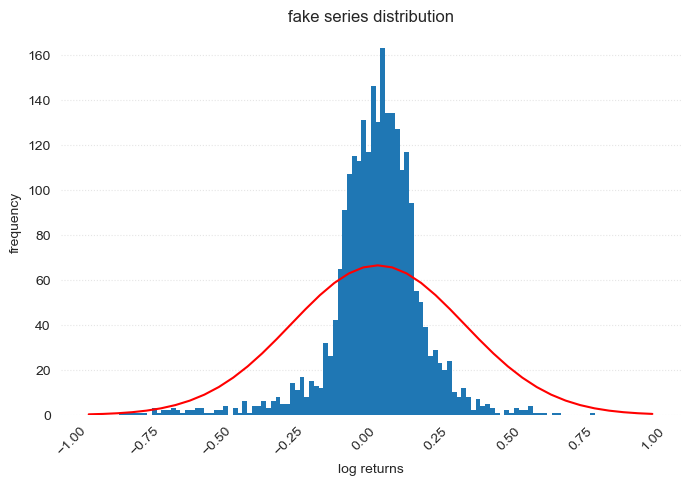

In [36]:
fig, ax = plt.subplots(figsize = (8, 5))

ax.hist(
    fake, 
    bins = 100,
    edgecolor = 'none'
)
x_axis = np.arange(-1, 1, 0.05)
ax.plot(
    x_axis, 
    norm.pdf(x_axis, 0, 0.3) * 50, 
    color= 'r'
)

for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
plt.xticks(rotation = 45, ha = 'right')
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xlabel('log returns')
plt.ylabel('frequency')
plt.title('fake series distribution')
plt.show()

In [37]:
fake_series = inverse(fake * log_max, params)

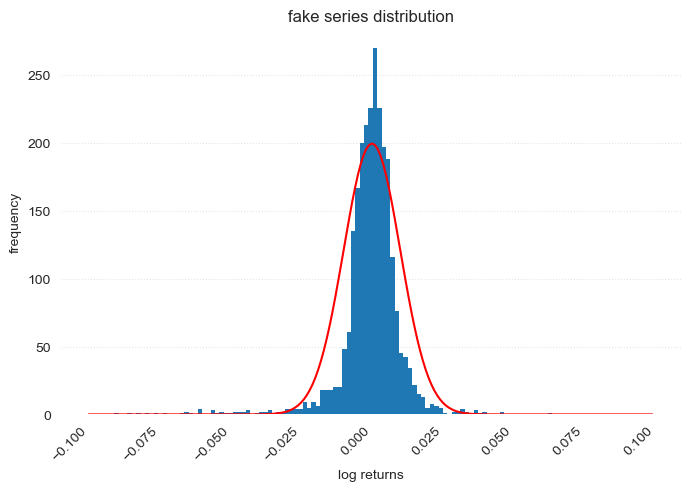

In [38]:
fig, ax = plt.subplots(figsize = (8, 5))

ax.hist(
    fake_series, 
    bins = 100,
    edgecolor = 'none'
)
x_axis = np.arange(-0.1, 0.1, 0.001)
ax.plot(
    x_axis, 
    norm.pdf(x_axis, 0, 0.01) * 5, 
    color= 'r'
)

for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
plt.xticks(rotation = 45, ha = 'right')
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xlabel('log returns')
plt.ylabel('frequency')
plt.title('fake series distribution')
plt.show()

### Visualize Results

In [39]:
def generate_fakes(n=1, cumsum=True):
    fakes = []
    for i in range(n):
        noise = torch.randn(1, len(processed), 3, device=device)
        fake = netG(noise).detach().cpu().reshape(len(processed)).numpy()
        sp500fake = inverse(fake * log_max, params) + log_mean
        fakes.append(sp500fake)
    if n > 1:
        if not cumsum:
            return pd.DataFrame(fakes).T
        fakes_df = pd.DataFrame(fakes).T.cumsum()
        return fakes_df
    elif not cumsum:
        return sp500fake
    return sp500fake.cumsum()

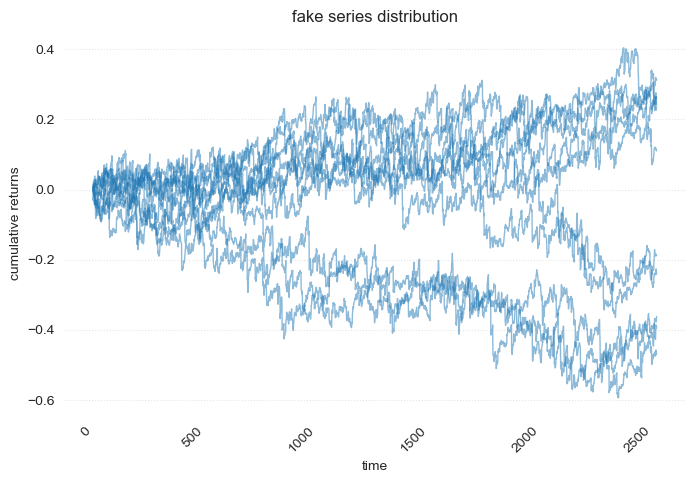

In [40]:
fig, ax = plt.subplots(figsize = (8, 5))

ax.plot(
    generate_fakes(n = 10),
    lw = 1,
    alpha = 0.5,
    color = 'tab:blue'
)

for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
plt.xticks(rotation = 45, ha = 'right')
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xlabel('time')
plt.ylabel('cumulative returns')
plt.title('fake series distribution')
plt.show()

In [45]:
comp_df = pd.DataFrame({'fake': generate_fakes(), 'real': log_ret.cumsum()})

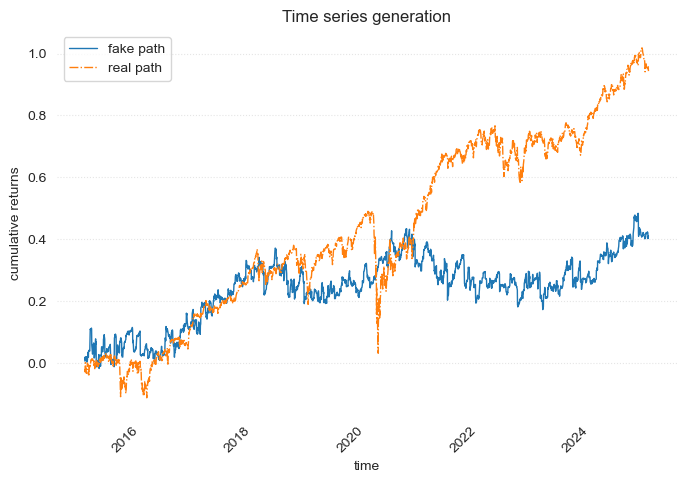

In [52]:
fig, ax = plt.subplots(figsize = (8, 5))

ax.plot(
    comp_df['fake'],
    lw = 1,
    label = 'fake path'
)
ax.plot(
    comp_df['real'],
    lw = 1,
    ls = '-.',
    label = 'real path'
)

for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
plt.xticks(rotation = 45, ha = 'right')
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.legend()
plt.xlabel('time')
plt.ylabel('cumulative returns')
plt.title('Time series generation')
plt.show()

### Autocorrelation

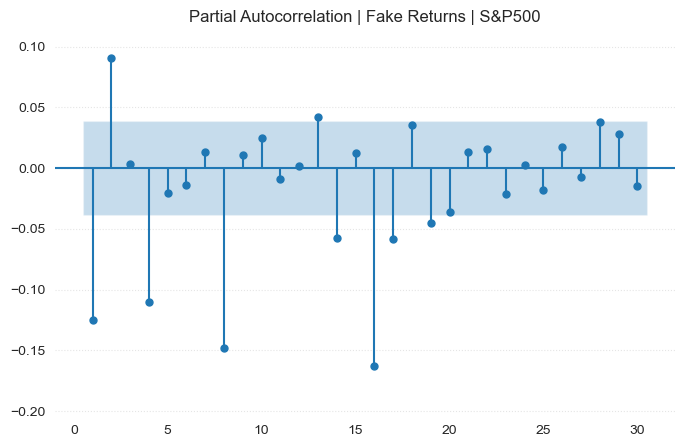

In [30]:
from statsmodels.graphics.tsaplots import plot_pacf

fig, ax = plt.subplots(figsize = (8, 5))
plot_pacf(
    comp_df['fake'].diff().dropna(), 
    ax = ax, 
    lags = range(1, 31), 
    auto_ylims = True
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title('Partial Autocorrelation | Fake Returns | S&P500')
plt.show()

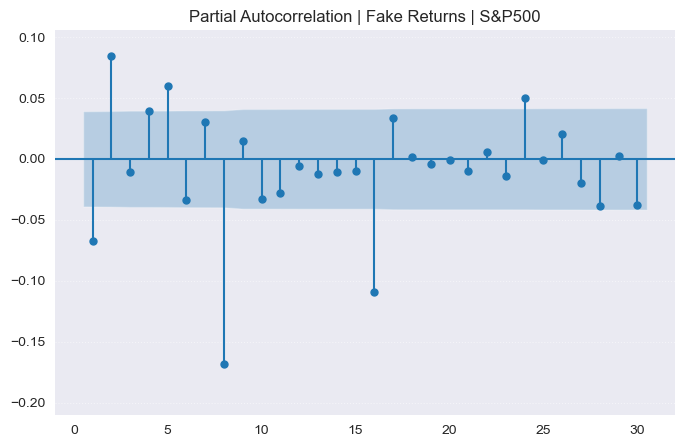

In [25]:
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(figsize = (8, 5))
plot_acf(
    comp_df['fake'].diff().dropna(), 
    ax = ax, 
    lags = range(1, 31), 
    auto_ylims = True
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title('Partial Autocorrelation | Fake Returns | S&P500')
plt.show()